In [1]:
import torch
from datasets import ALOVDataset, ILSVRC2014_DET_Dataset
from torchvision import transforms
from helper import *
import argparse
import numpy as np

## Load ALOV and ImageNet datasets

In [2]:
use_gpu = torch.cuda.is_available()
kSaveModel = 20000 # save model after every 20000 steps
kGeneratedExamplesPerImage = 10; # generate 10 synthetic samples per image in a dataset
transform = transforms.Compose([Normalize(), ToTensor()])

In [3]:
alov = ALOVDataset('../data/alov300/imagedata++/',
                   '../data/alov300/alov300++_rectangleAnnotation_full/',
                   transform)

Parsing ALOV dataset...
ALOV dataset parsing done.
Total number of annotations in ALOV Dataset = 16023


In [4]:
lambda_shift_frac = 5
lambda_scale_frac = 15
min_scale = -0.4
max_scale = 0.4
imagenet = ILSVRC2014_DET_Dataset('../data/imagenet_img/',
                                   '../data/imagenet_bbox/',
                                   transform,
                                   lambda_shift_frac,
                                   lambda_scale_frac,
                                   min_scale,
                                   max_scale)

Parsing ImageNet dataset...
ImageNet dataset parsing done.
Total number of annotations in ImageNet Dataset = 239283


## Visualize batch of 1 true + 10 synthetic (random crop) samples

In [5]:
""" Given a dataset, returns pytorch tensor batch of 11 samples """ 
def make_tensor_samples(dataset, args):
    transform = transforms.Compose([ToTensor()])
    idx = np.random.randint(dataset.len, size=1)[0]
    orig_sample = dataset.get_orig_sample(idx) # unscaled original sample (single image and bb)
    true_sample = dataset.get_sample(idx) # cropped scaled sample (two frames and bb)
    true_tensor = transform(true_sample)

    origimg = orig_sample['image']
    origbb = orig_sample['bb']
    x1_batch = torch.Tensor(kGeneratedExamplesPerImage + 1, 3, 227, 227)
    x2_batch = torch.Tensor(kGeneratedExamplesPerImage + 1, 3, 227, 227)
    y_batch = torch.Tensor(kGeneratedExamplesPerImage + 1, 4)

    # initialize batch with the true sample
    x1_batch[0,:,:,:] = true_tensor['previmg']
    x2_batch[0,:,:,:] = true_tensor['currimg']
    y_batch[0,:] = true_tensor['currbb']

    for i in range(kGeneratedExamplesPerImage):
        sample = {'image': origimg, 'bb': origbb}
        prevbb = random_crop(sample,
                             lambda_scale_frac,
                             lambda_shift_frac,
                             min_scale,
                             max_scale)

        # Crop previous image with height and width twice the prev bounding box height and width
        # Scale the cropped image to (227,227,3)
        crop_curr = transforms.Compose([CropCurr()])
        scale = Rescale((227,227))
        transform_prev = transforms.Compose([CropPrev(), scale])
        prev_img = transform_prev({'image':origimg, 'bb':origbb})['image']
        # Crop current image with height and width twice the prev bounding box height and width
        # Scale the cropped image to (227,227,3)
        curr_obj = crop_curr({'image':origimg, 'prevbb':prevbb, 'currbb':origbb})
        curr_obj = scale(curr_obj)
        curr_img = curr_obj['image']
        currbb = curr_obj['bb']
        currbb = np.array(currbb)
        sample = {'previmg': prev_img,
                'currimg': curr_img,
                'currbb' : currbb
                }
        sample = transform(sample)
        x1_batch[i+1,:,:,:] = sample['previmg']
        x2_batch[i+1,:,:,:] = sample['currimg']
        y_batch[i+1,:] = sample['currbb']

    return x1_batch, x2_batch, y_batch

### Visualize a batch (11 samples) from ALOV dataset

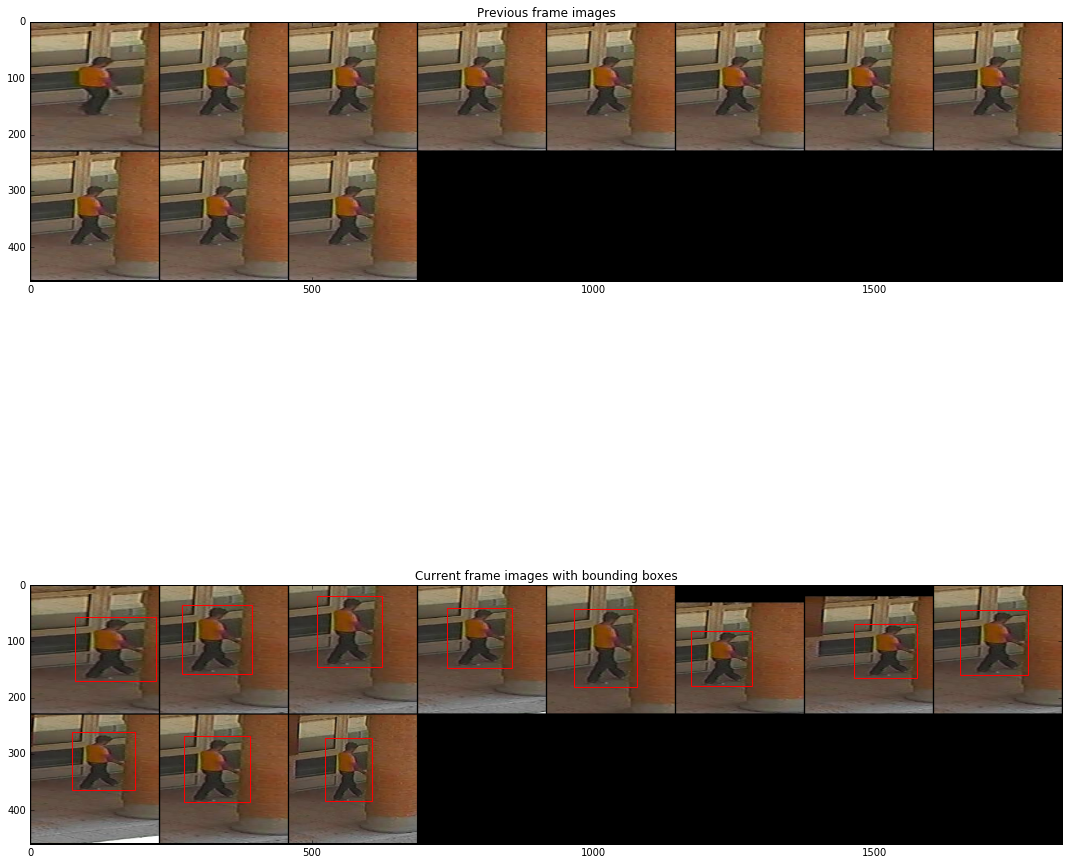

In [6]:
x1_batch, x2_batch, y_batch = make_tensor_samples(alov, None)
batch = {'previmg': x1_batch, 'currimg': x2_batch, 'currbb': y_batch}
show_batch(batch)

### Visualize a batch (11 samples) from ImageNet dataset

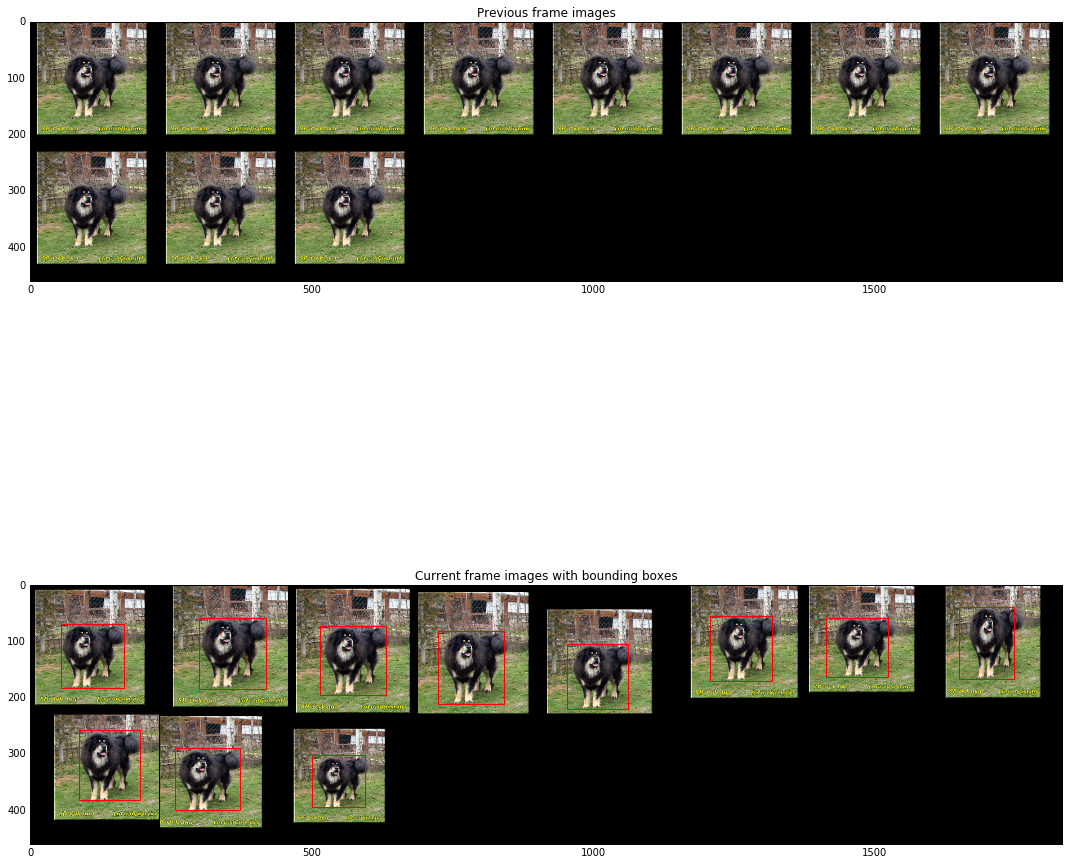

In [7]:
x1_batch, x2_batch, y_batch = make_tensor_samples(imagenet, None)
batch = {'previmg': x1_batch, 'currimg': x2_batch, 'currbb': y_batch}
show_batch(batch)

## Visualize training batch of 50 samples 

In [8]:
""" Implements GOTURN batch formation regimen """
def get_training_batch(running_batch_idx, running_batch, dataset):
    done = 0
    N = kGeneratedExamplesPerImage+1
    train_batch = None

    x1_batch, x2_batch, y_batch = make_tensor_samples(dataset, None)
    if running_batch_idx + N <= 50:
        running_batch['previmg'][running_batch_idx:running_batch_idx+N,:,:,:] = x1_batch
        running_batch['currimg'][running_batch_idx:running_batch_idx+N,:,:,:] = x2_batch
        running_batch['currbb'][running_batch_idx:running_batch_idx+N,:] = y_batch
        running_batch_idx = (running_batch_idx+N)
    elif running_batch_idx + N > 50:
        done = 1
        count_in = 50-running_batch_idx
 #       print "count_in =", count_in
        if count_in > 0:
            running_batch['previmg'][running_batch_idx:running_batch_idx+count_in,:,:,:] = x1_batch[:count_in,:,:,:]
            running_batch['currimg'][running_batch_idx:running_batch_idx+count_in,:,:,:] = x2_batch[:count_in,:,:,:]
            running_batch['currbb'][running_batch_idx:running_batch_idx+count_in,:] = y_batch[:count_in,:]
            running_batch_idx = (running_batch_idx+N) % 50
            train_batch = running_batch
            running_batch = {'previmg': torch.Tensor(50, 3, 227, 227),
                            'currimg': torch.Tensor(50, 3, 227, 227),
                            'currbb': torch.Tensor(50, 4)}
            running_batch['previmg'][:running_batch_idx,:,:,:] = x1_batch[count_in:,:,:,:]
            running_batch['currimg'][:running_batch_idx,:,:,:] = x2_batch[count_in:,:,:,:]
            running_batch['currbb'][:running_batch_idx,:] = y_batch[count_in:,:]
        else:
            train_batch = running_batch
            running_batch_idx = 0
            running_batch['previmg'][running_batch_idx:running_batch_idx+N,:,:,:] = x1_batch
            running_batch['currimg'][running_batch_idx:running_batch_idx+N,:,:,:] = x2_batch
            running_batch['currbb'][running_batch_idx:running_batch_idx+N,:] = y_batch
            running_batch_idx = (running_batch_idx+N)

    return running_batch, train_batch, done, running_batch_idx

torch.Size([50, 3, 227, 227])
torch.Size([50, 3, 227, 227])
torch.Size([50, 4])


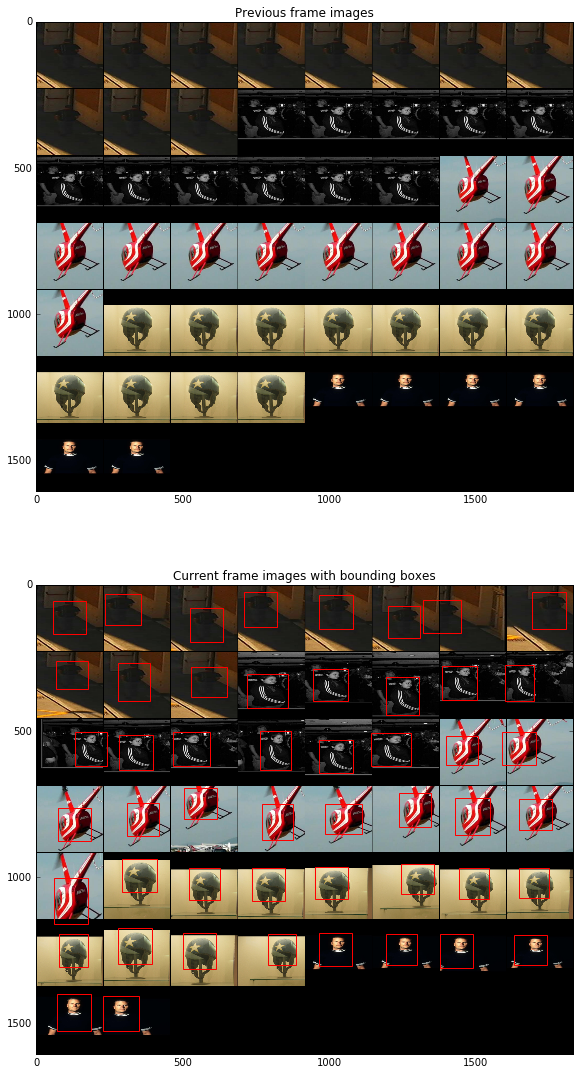

In [9]:
running_batch_idx = 0
running_batch = {'previmg': torch.Tensor(50, 3, 227, 227),
         'currimg': torch.Tensor(50, 3, 227, 227),
         'currbb': torch.Tensor(50, 4)}
datasets = [alov, imagenet]
done = 0
while 1:
    for i, dataset in enumerate(datasets):
        running_batch, train_batch, done, running_batch_idx = get_training_batch(running_batch_idx, running_batch, dataset)
    #            print 'running_batch_idx =', running_batch_idx
        if done:
            print train_batch['previmg'].size()
            print train_batch['currimg'].size()
            print train_batch['currbb'].size()
            show_batch(train_batch)
            break
    if done:
        break

## Visualize running batch for sanity check

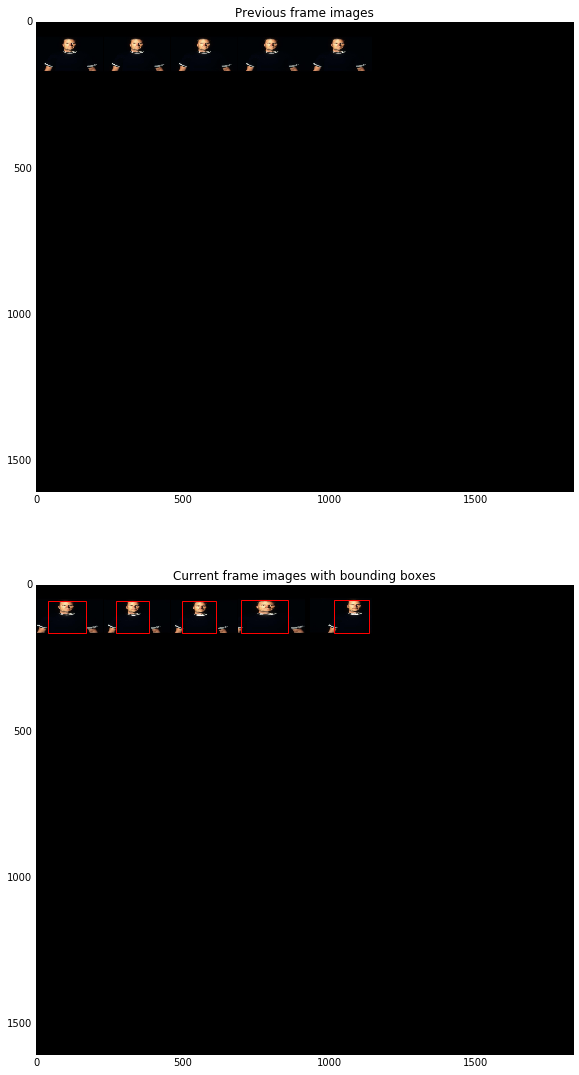

In [10]:
show_batch(running_batch)